<a href="https://colab.research.google.com/github/Krumpu/Homework_ICA/blob/main/HW_1_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

In [28]:
url = 'https://raw.githubusercontent.com/Krumpu/Homework_ICA/main/Data-Melbourne_F.csv'
df = pd.read_csv(url)

# We can remove "year", "month" and "day" columns,
# since we did no time series analysis today... 
# "VG" is removed, we do not have any info about
df = df.drop(["VG", 'year', 'month', 'day'], axis=1)

# Information about our data set
print('Number of Observations (N): ', df.shape[0])
print('Number of Predictor Variables (D): ', df.shape[1])
# We have no classes

df.head()

   avg_outflow  avg_inflow  total_grid    Am    BOD     COD      TN     T  \
0        2.941       2.589      175856  27.0  365.0   730.0  60.378  19.3   
1        2.936       2.961      181624  25.0  370.0   740.0  60.026  17.1   
2        2.928       3.225      202016  42.0  418.0   836.0  64.522  16.8   
3        2.928       3.354      207547  36.0  430.0   850.0  63.000  14.6   
4        2.917       3.794      202824  46.0  508.0  1016.0  65.590  13.4   

     TM    Tm  SLP   H    PP    VV     V    VM    VG  
0  25.1  12.6  0.0  56  1.52  10.0  26.9  53.5  79.5  
1  23.6  12.3  0.0  63  0.00  10.0  14.4  27.8   0.0  
2  27.2   8.8  0.0  47  0.25  10.0  31.9  61.1  77.8  
3  19.9  11.1  0.0  49  0.00  10.0  27.0  38.9  53.5  
4  19.1   8.0  0.0  65  0.00  10.0  20.6  35.2  53.5  
Number of Observations (N):  1382
Number of Predictor Variables (D):  17


,name,mean,standard_deviation,skewness
1,avg_outflow,3.930608,1.228778,0.380545
2,avg_inflow,4.506338,1.439583,3.751865
3,total_grid,275159.089001,44640.533689,-0.148416
4,Am,39.222302,7.761598,0.310626
5,BOD,382.061708,85.996012,1.234594
6,COD,845.960434,145.416540,0.743344
7,TN,62.740752,3.571035,-0.256672
8,T,15.036686,5.398491,0.552359
9,TM,20.530897,7.096760,0.485291
10,Tm,10.037337,4.656887,0.498749


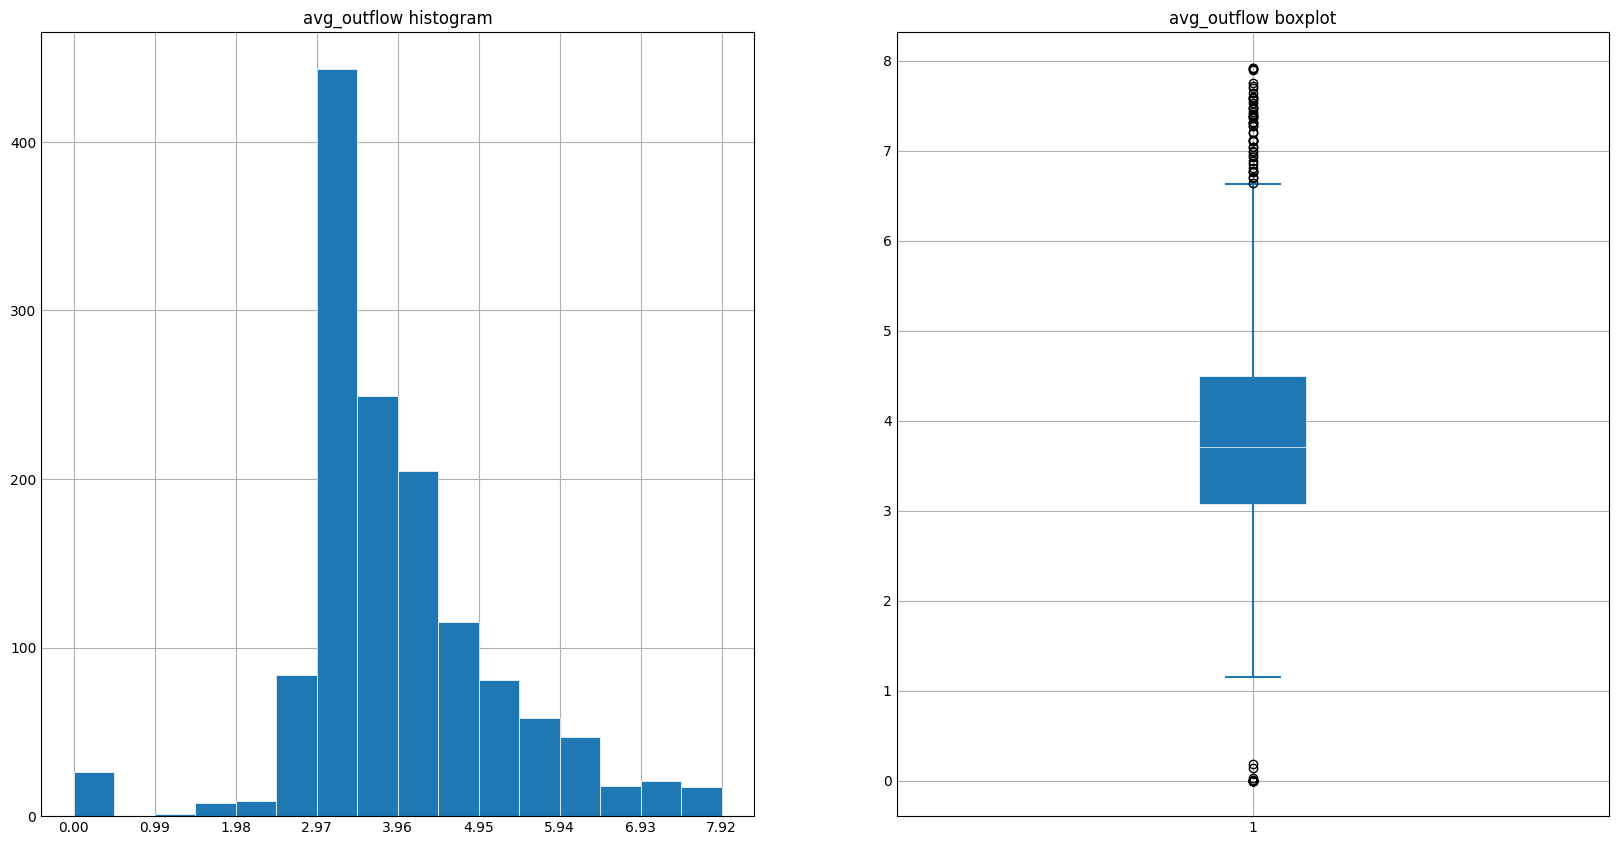

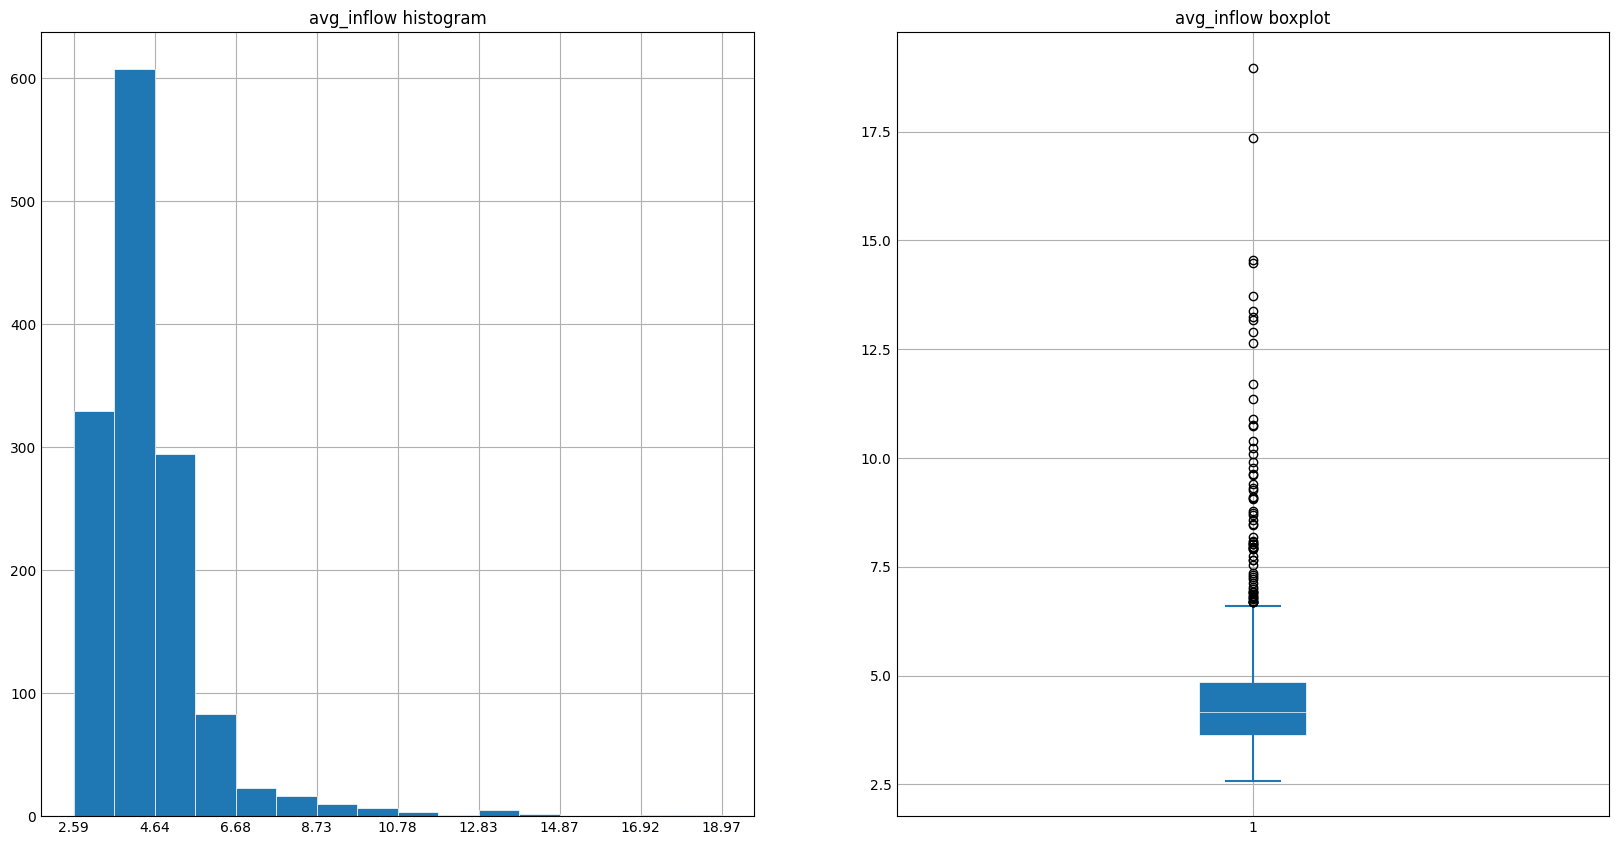

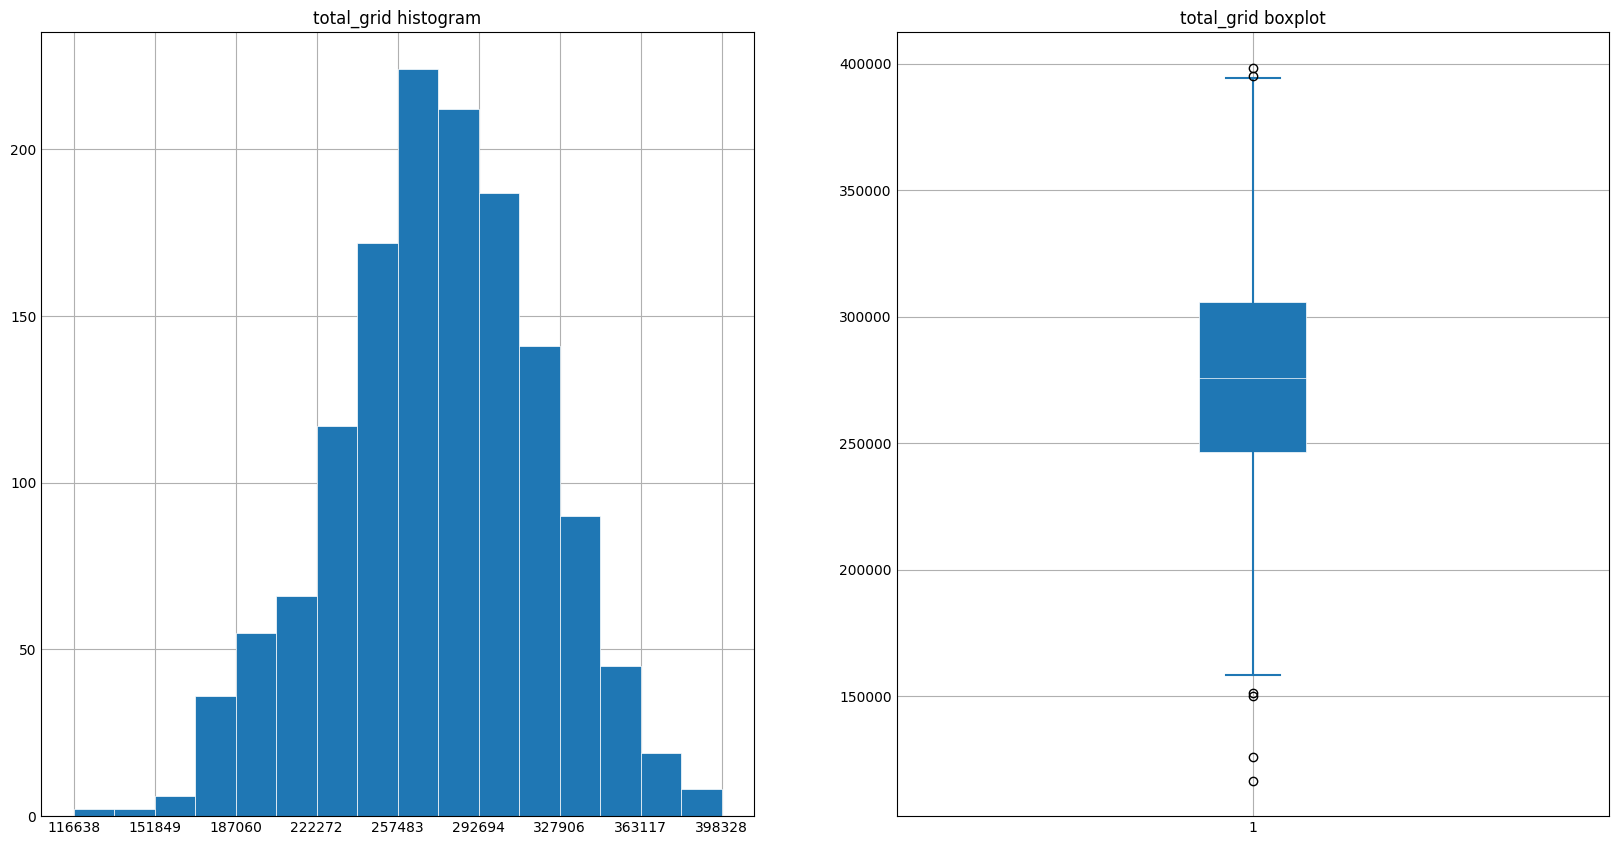

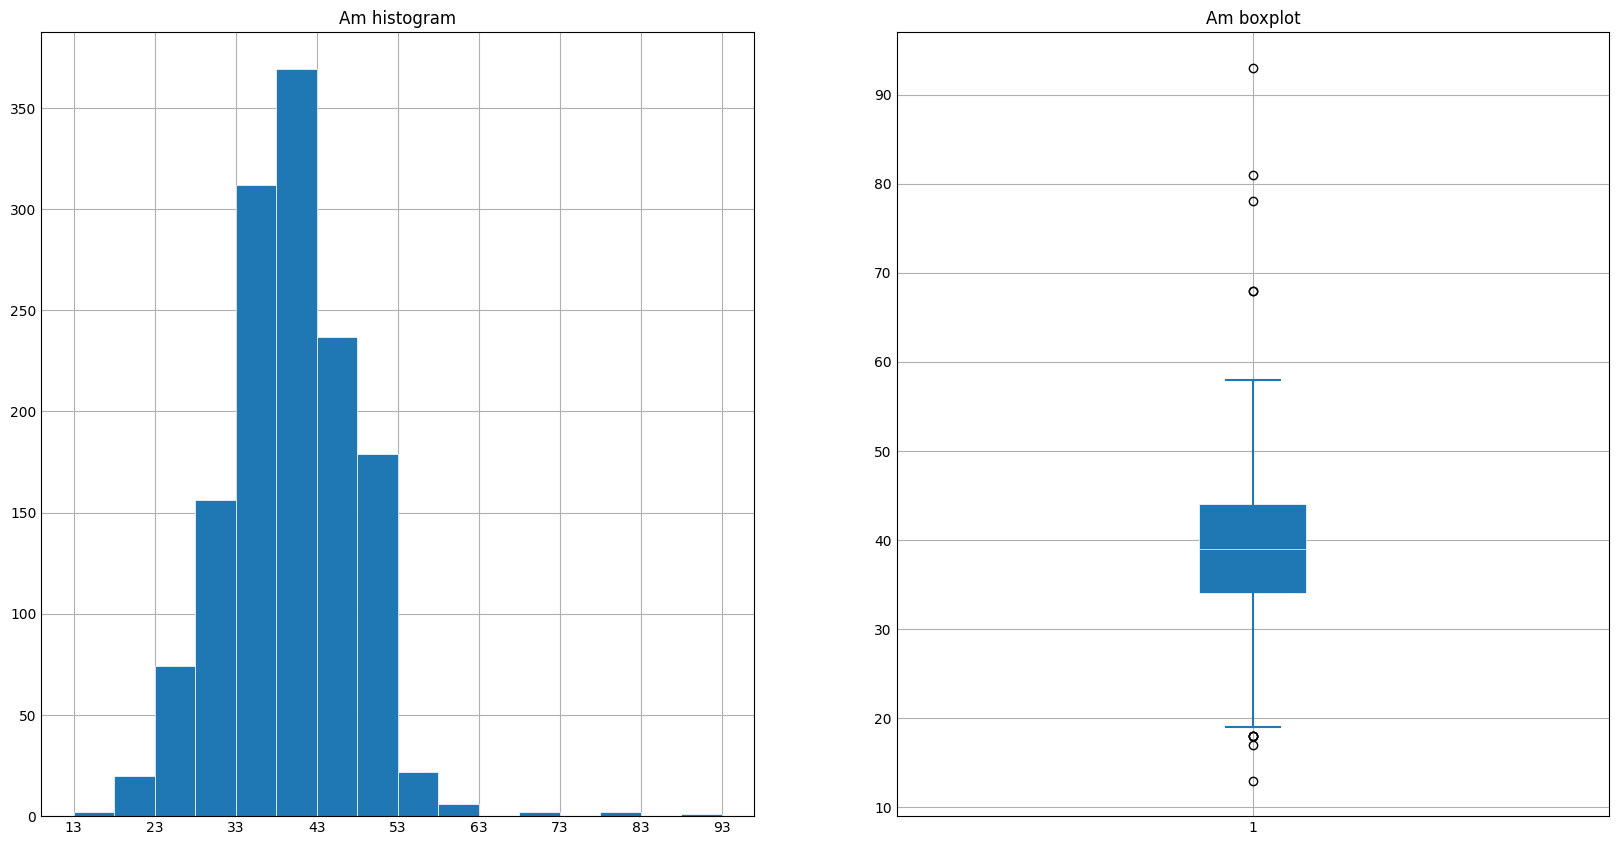

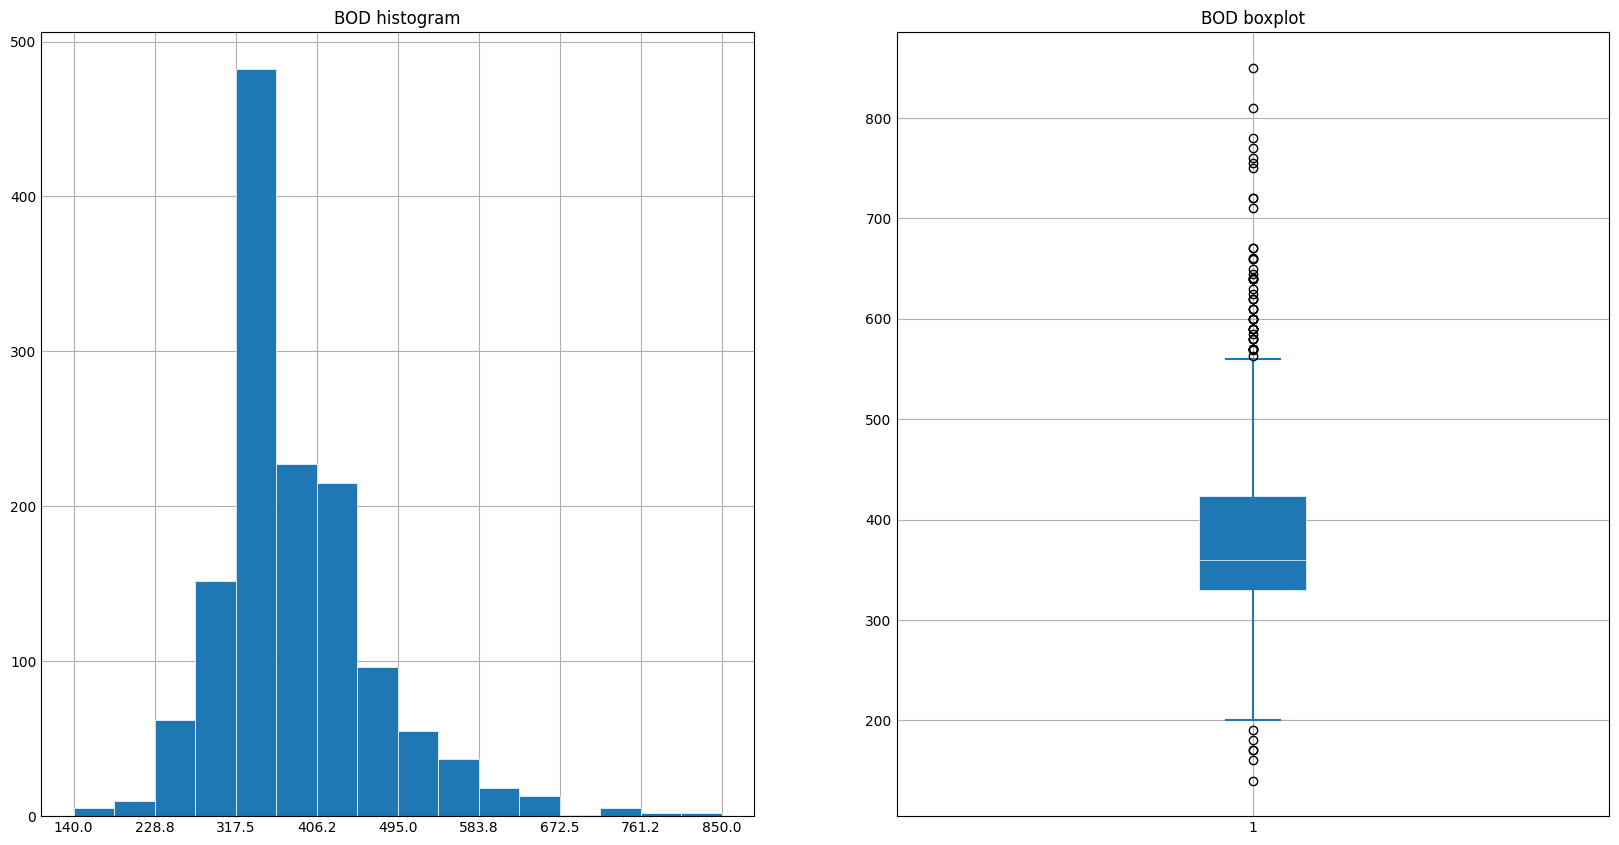

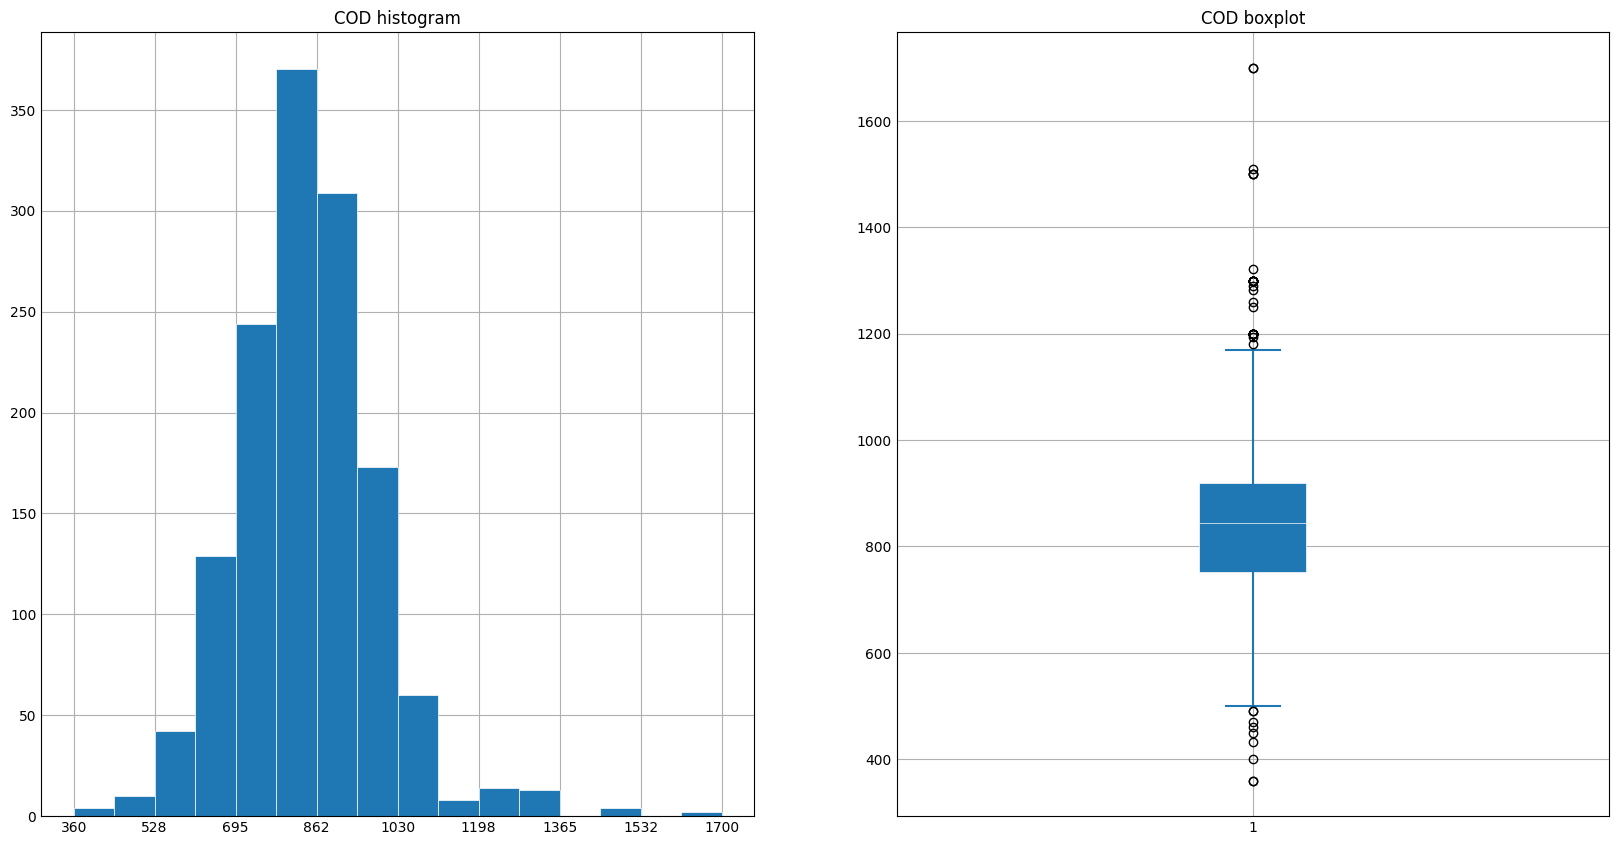

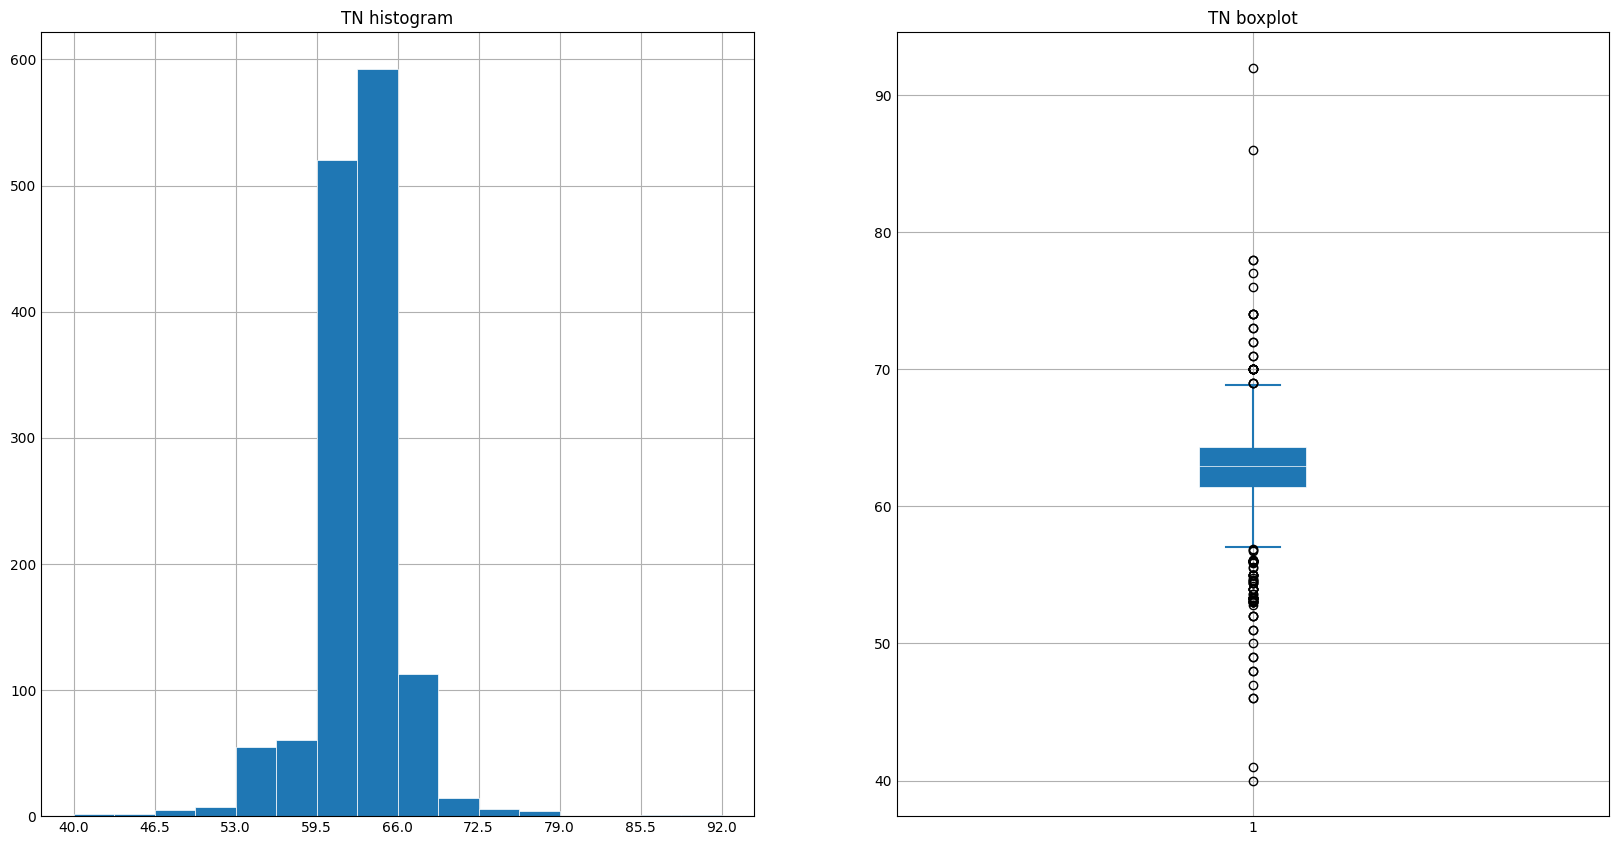

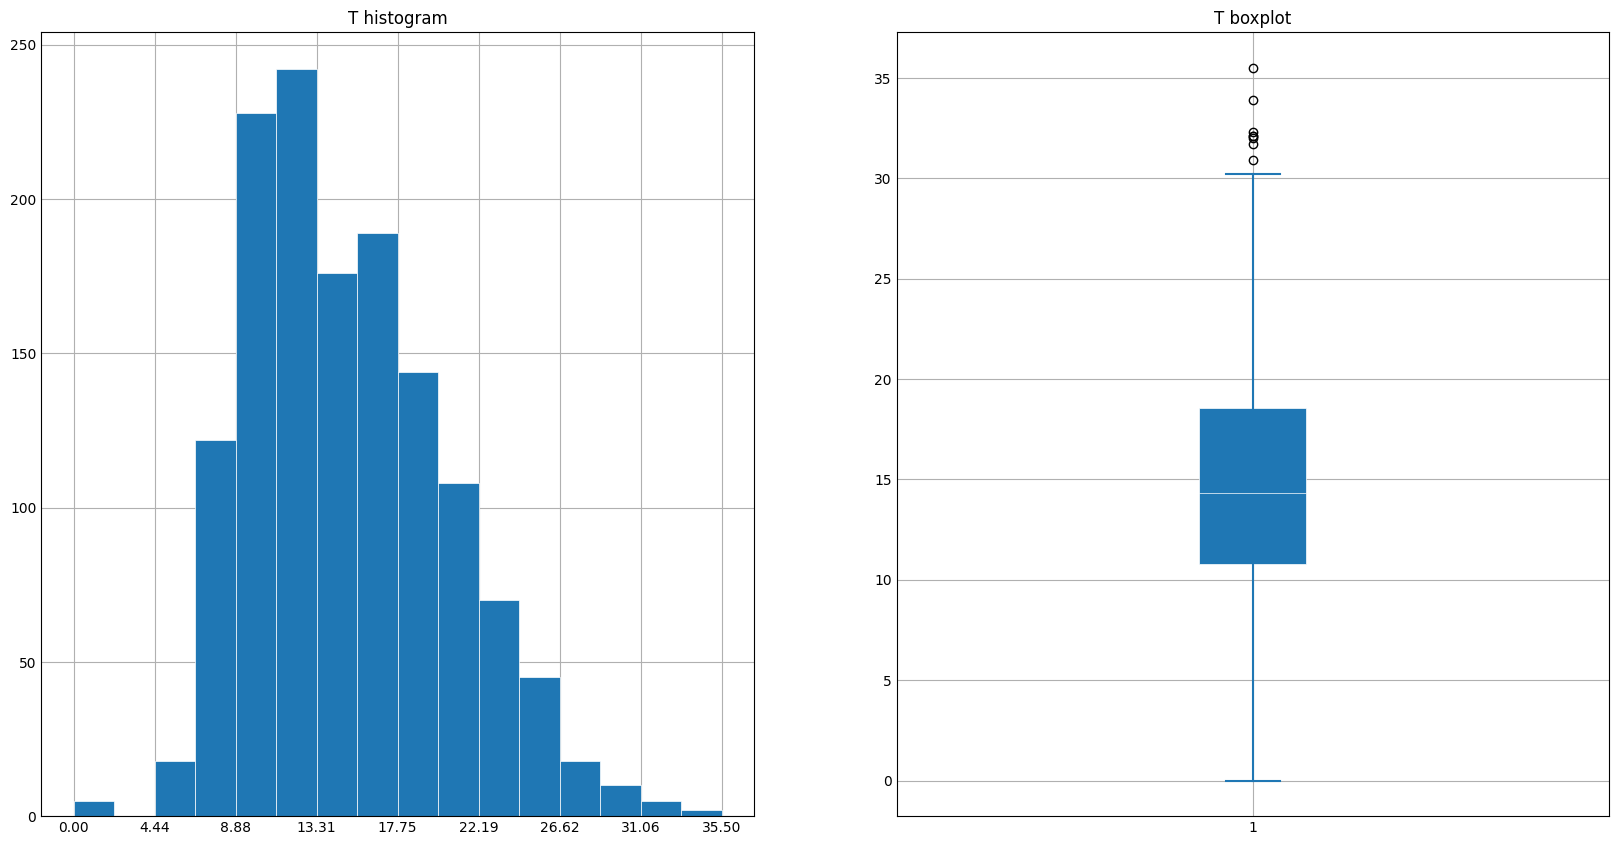

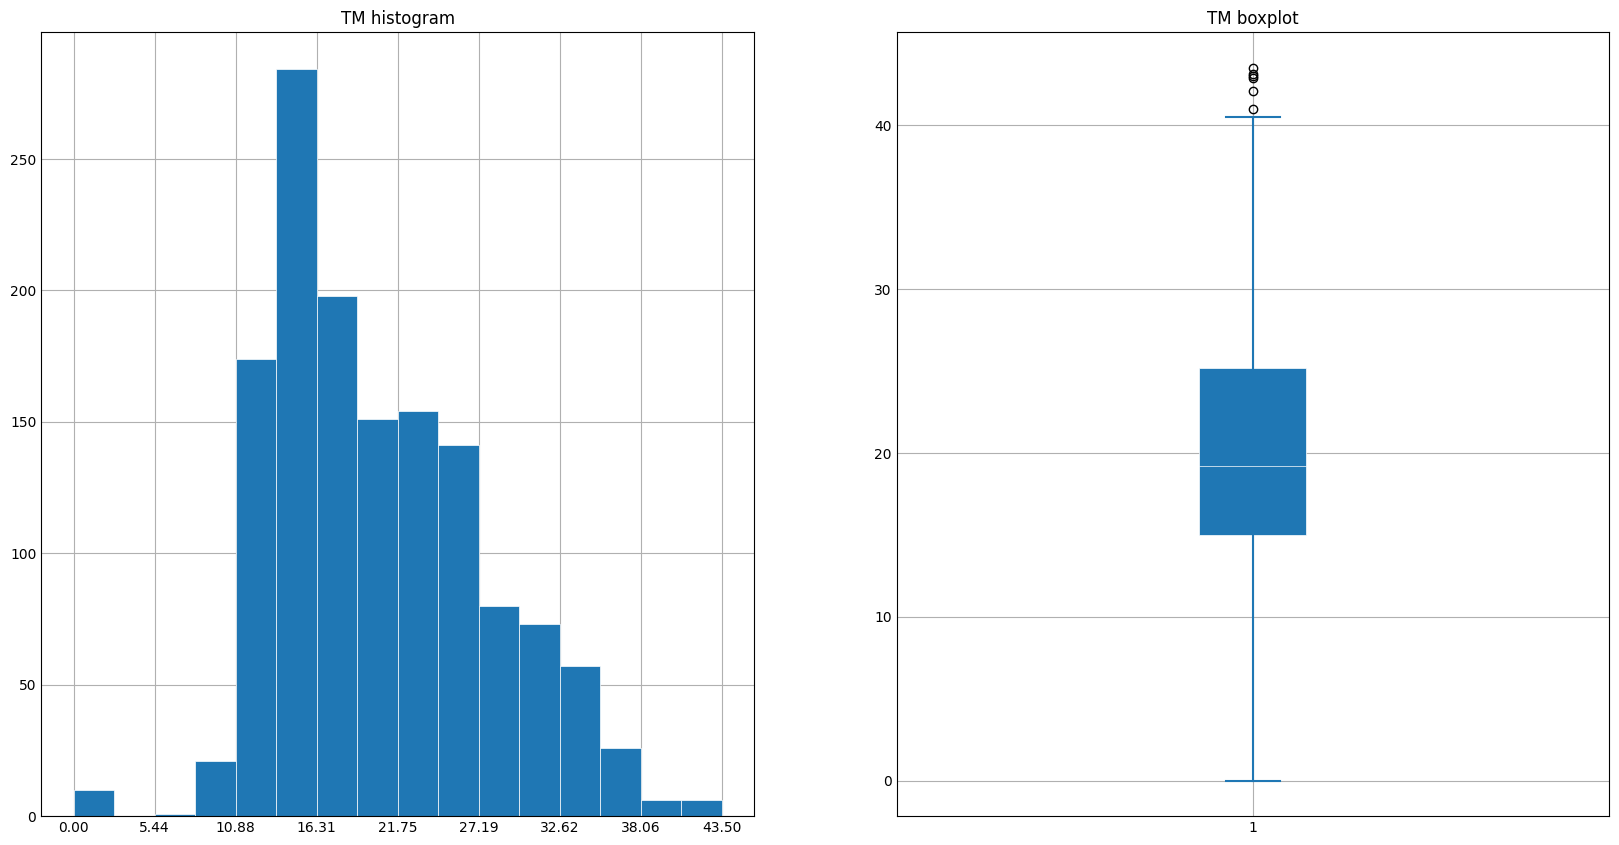

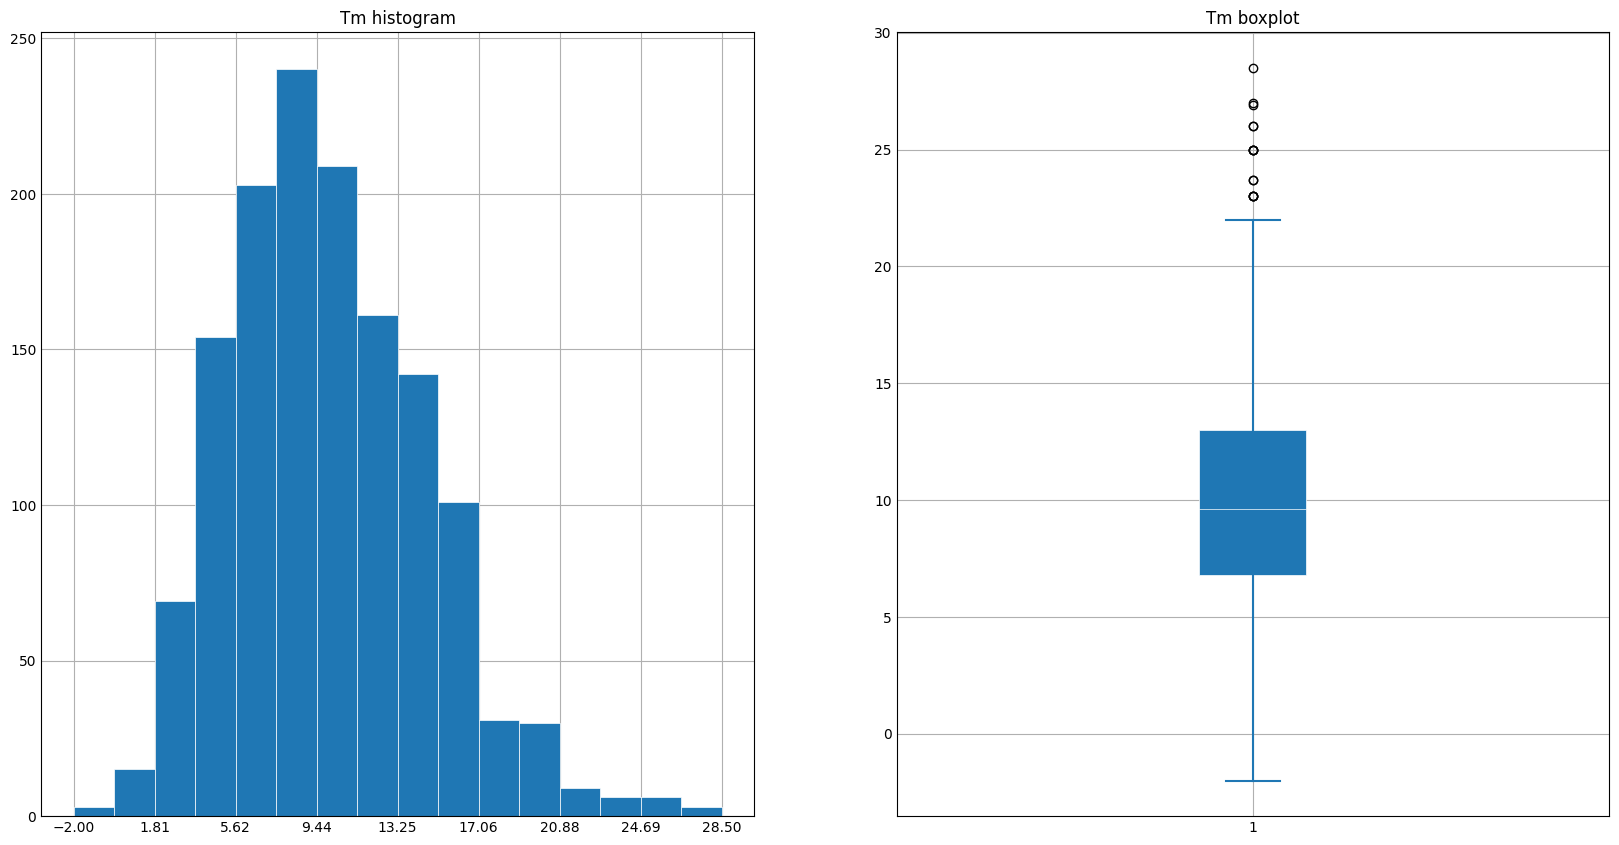

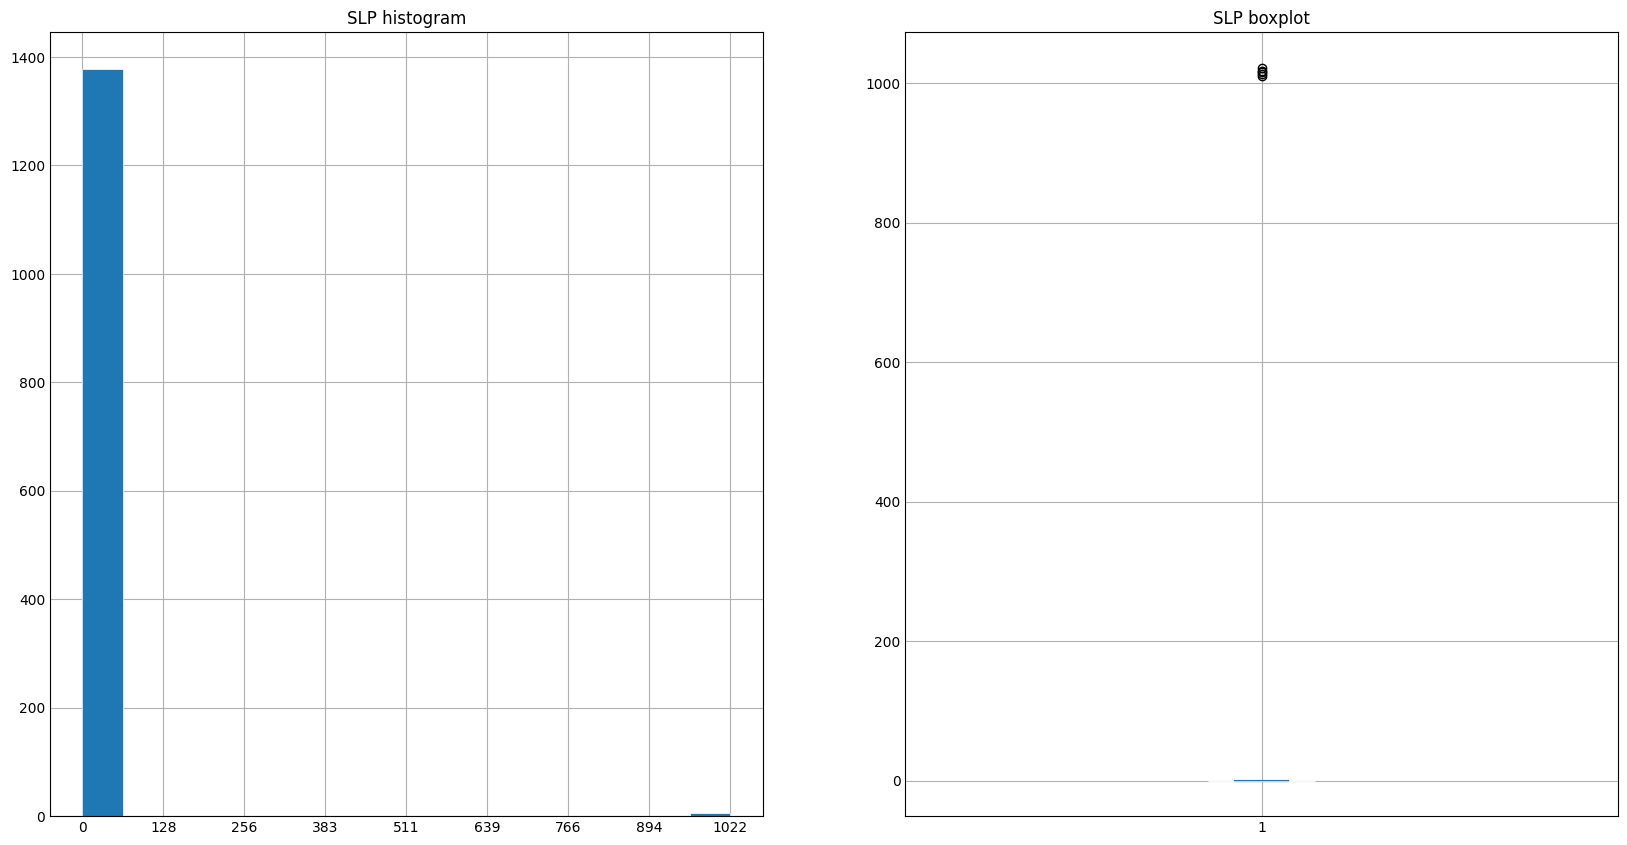

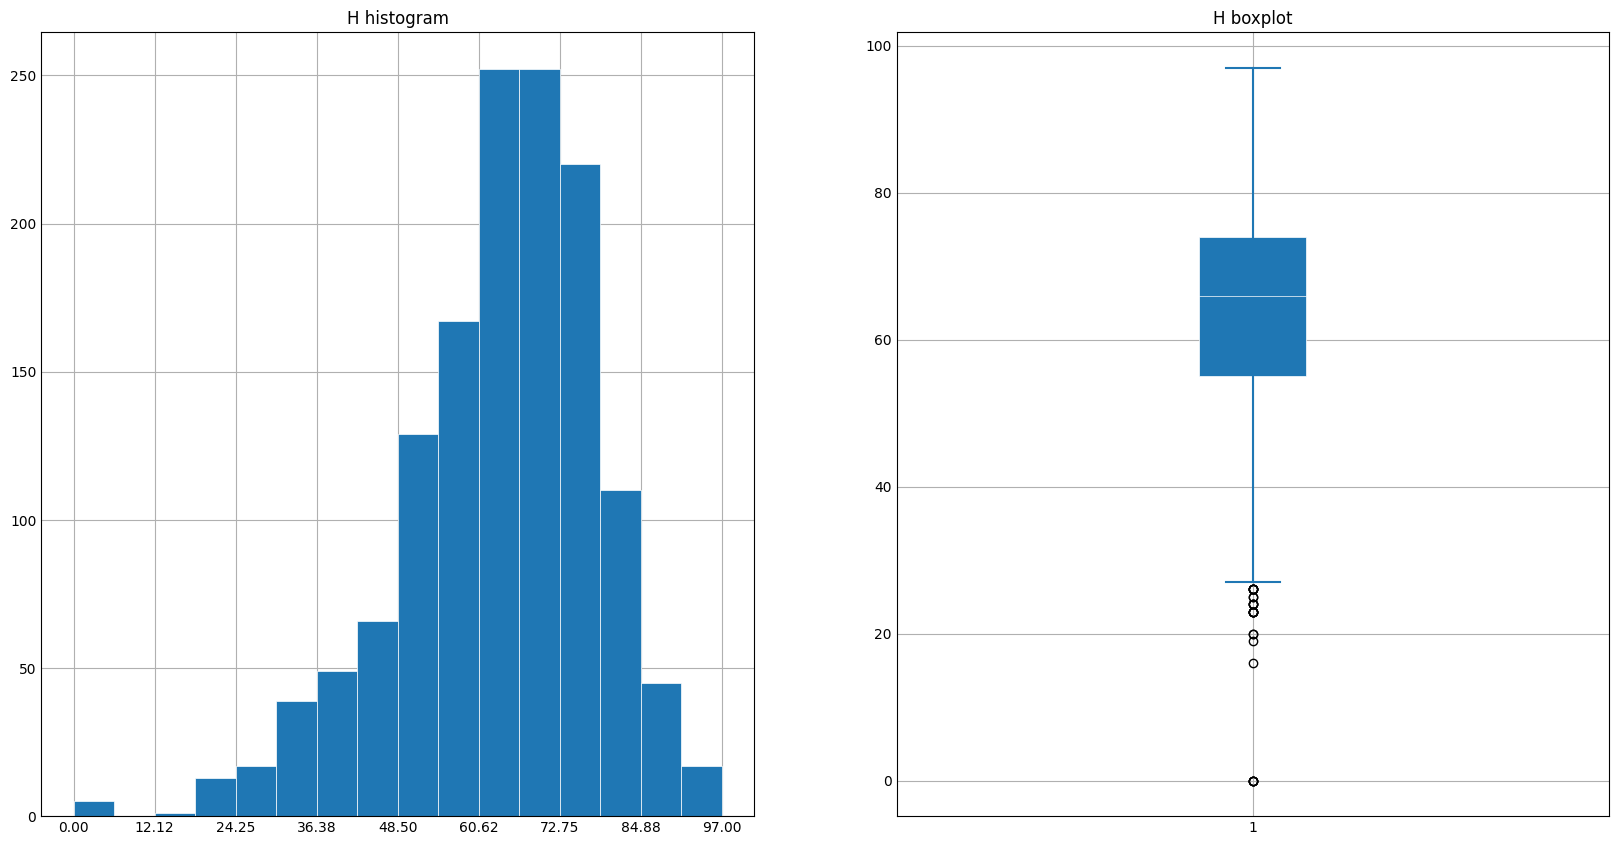

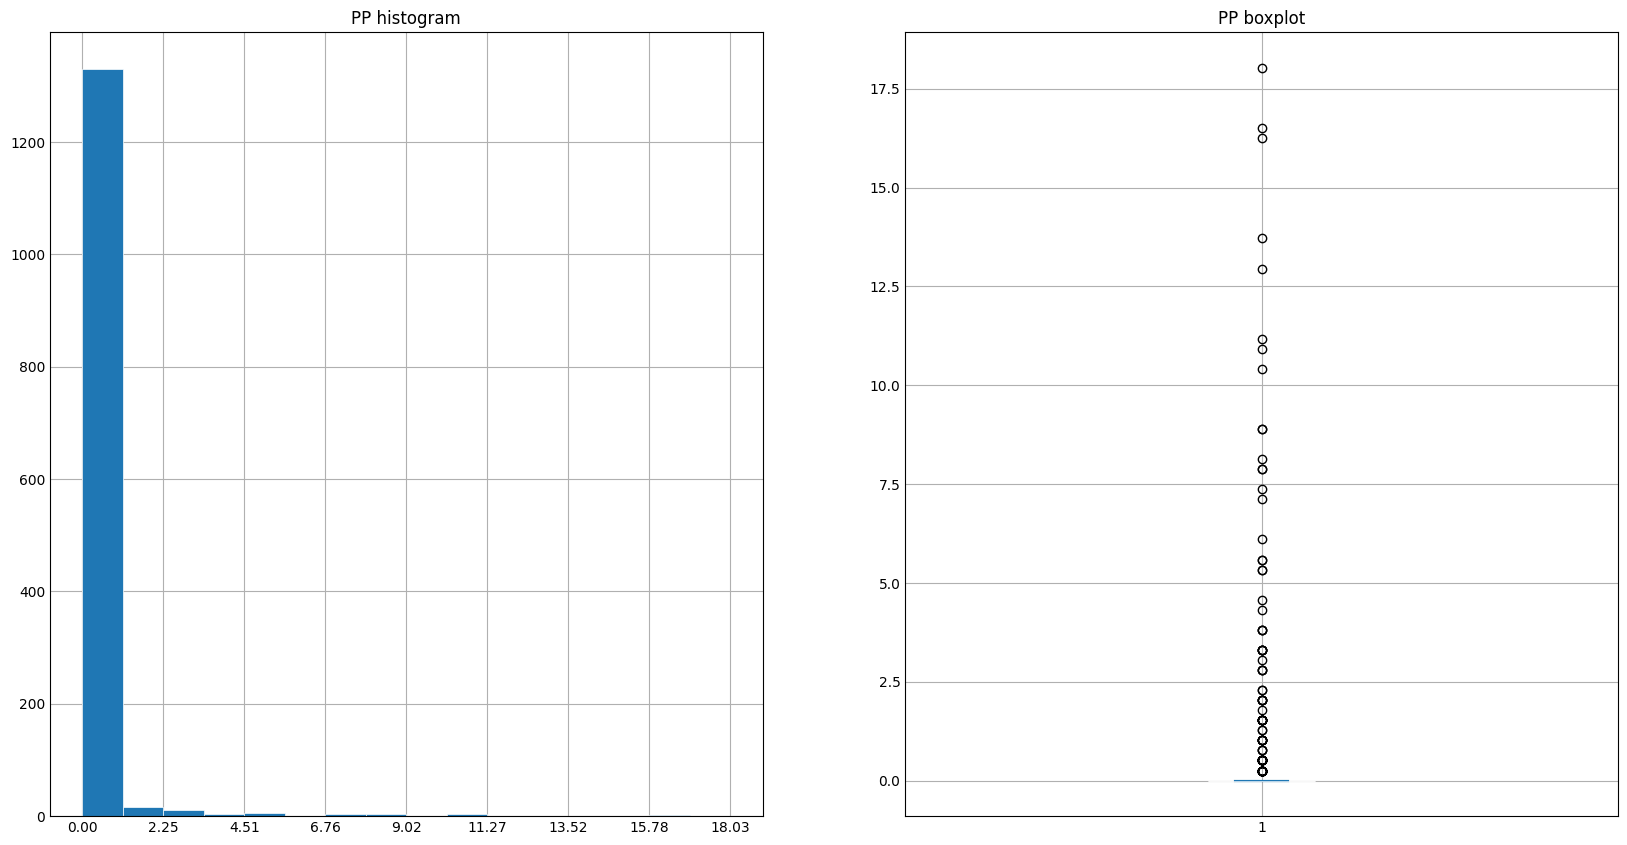

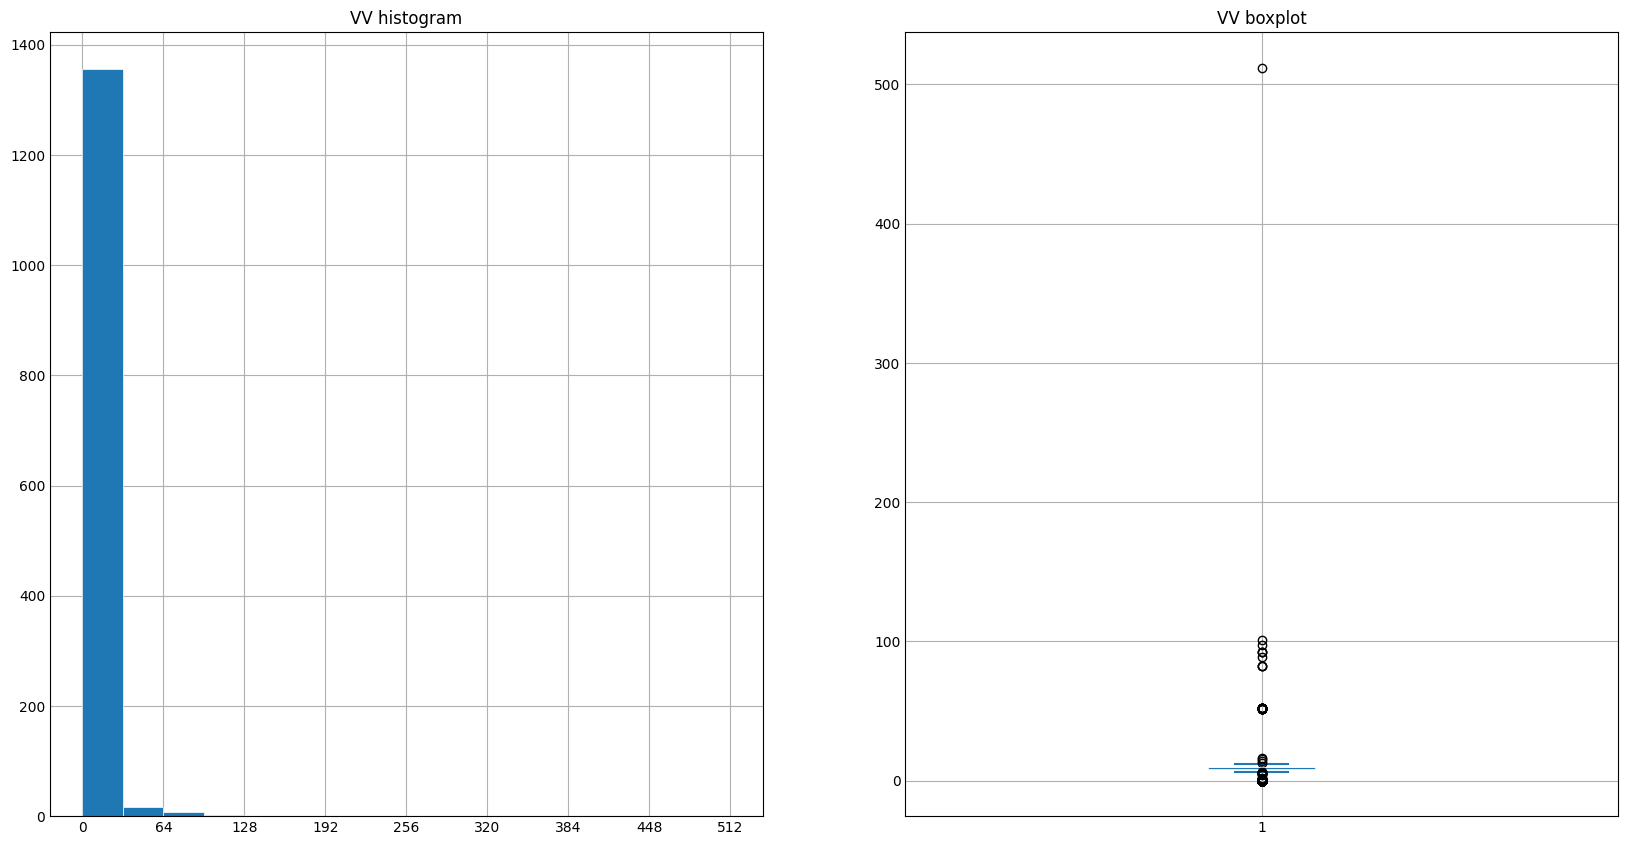

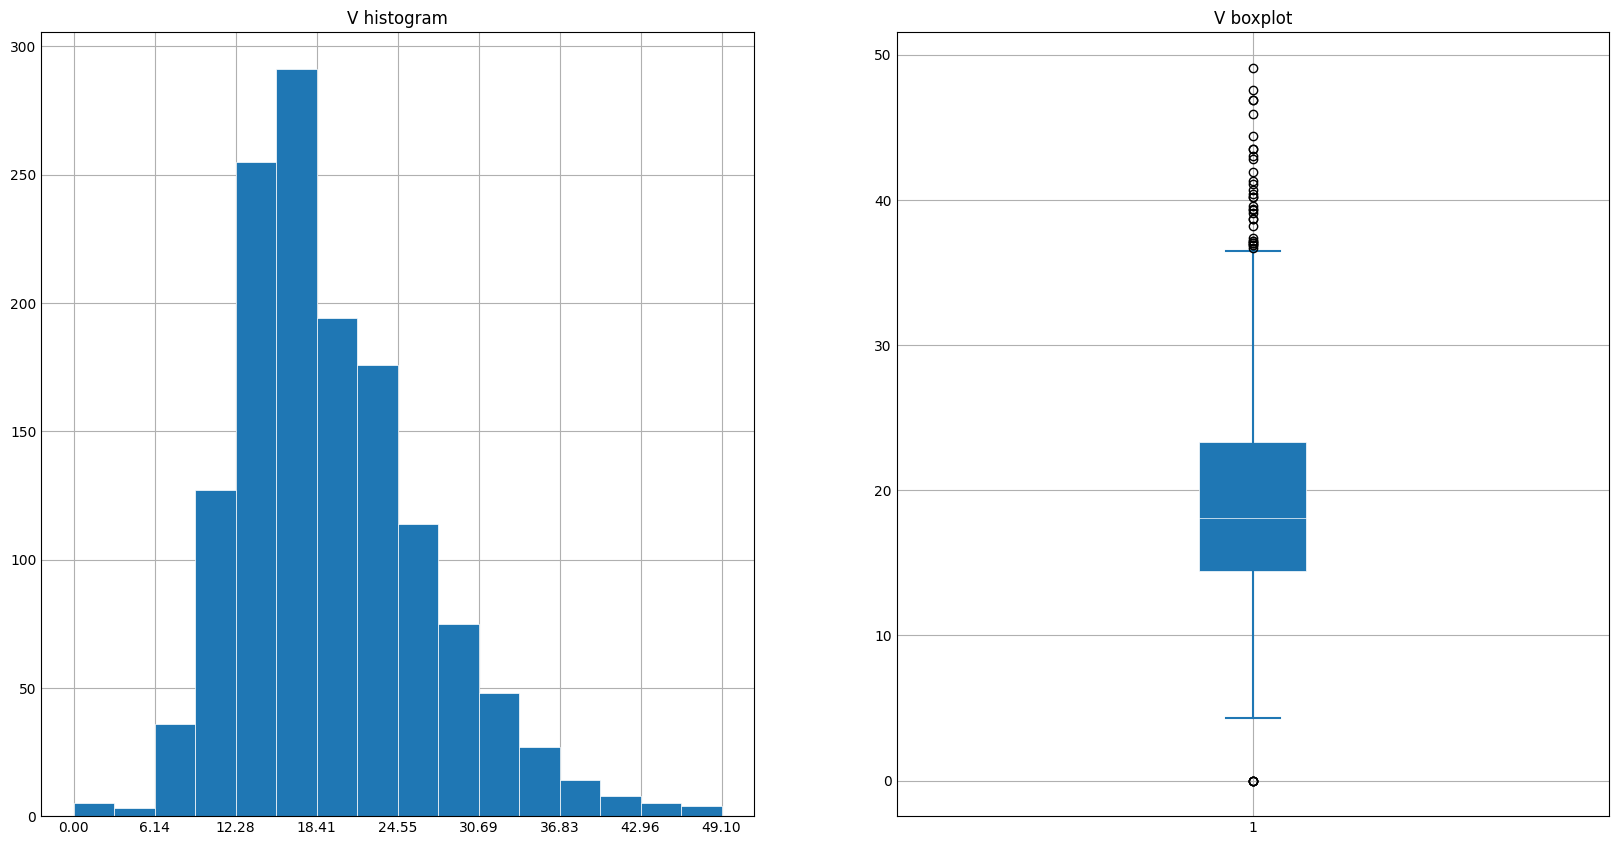

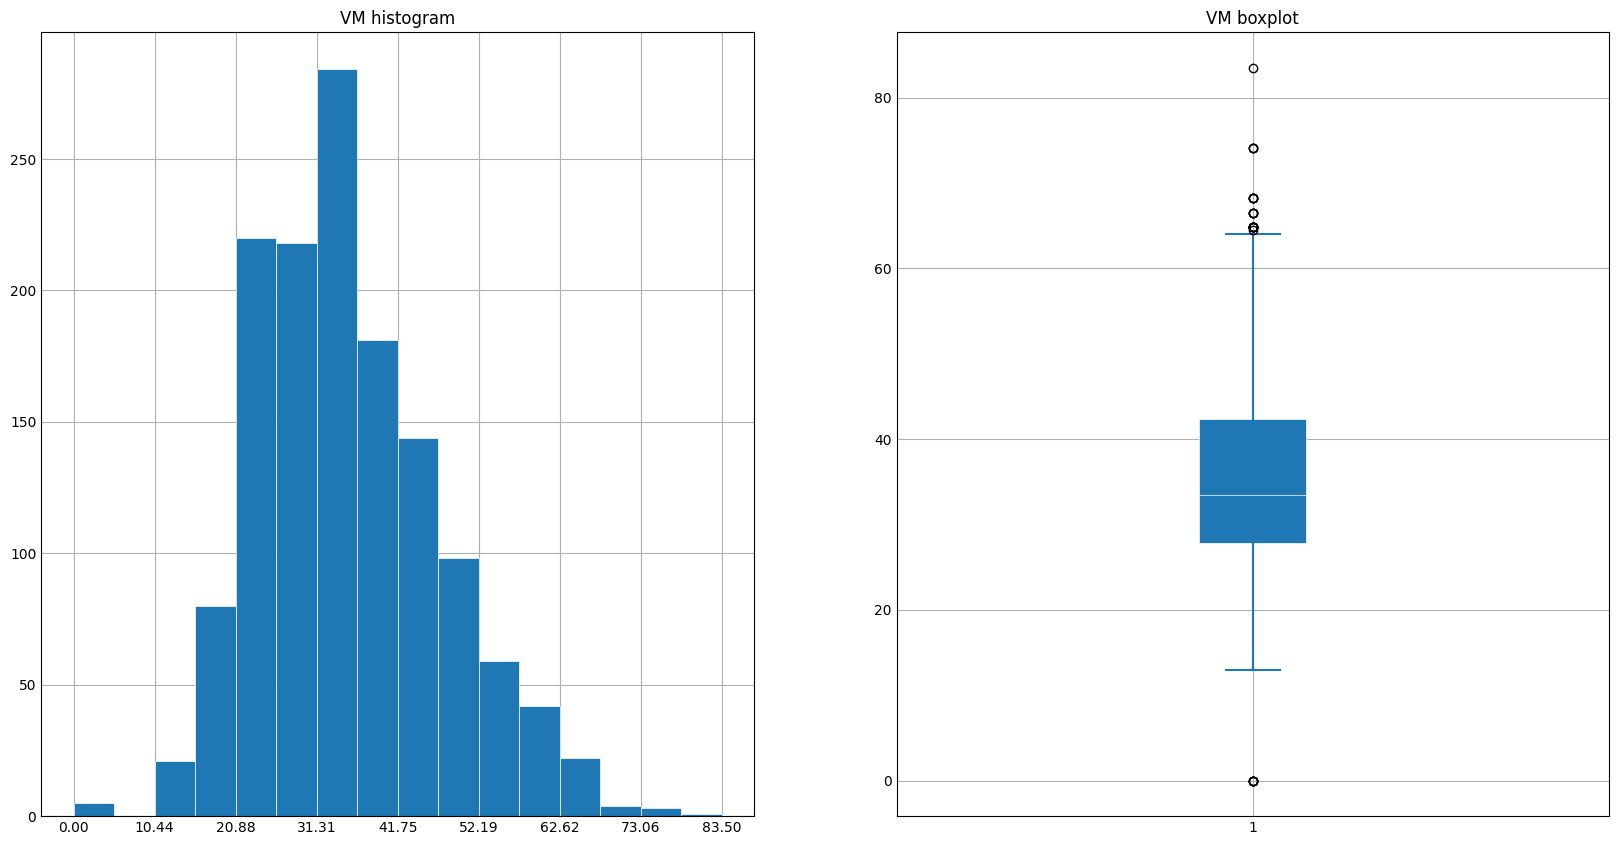

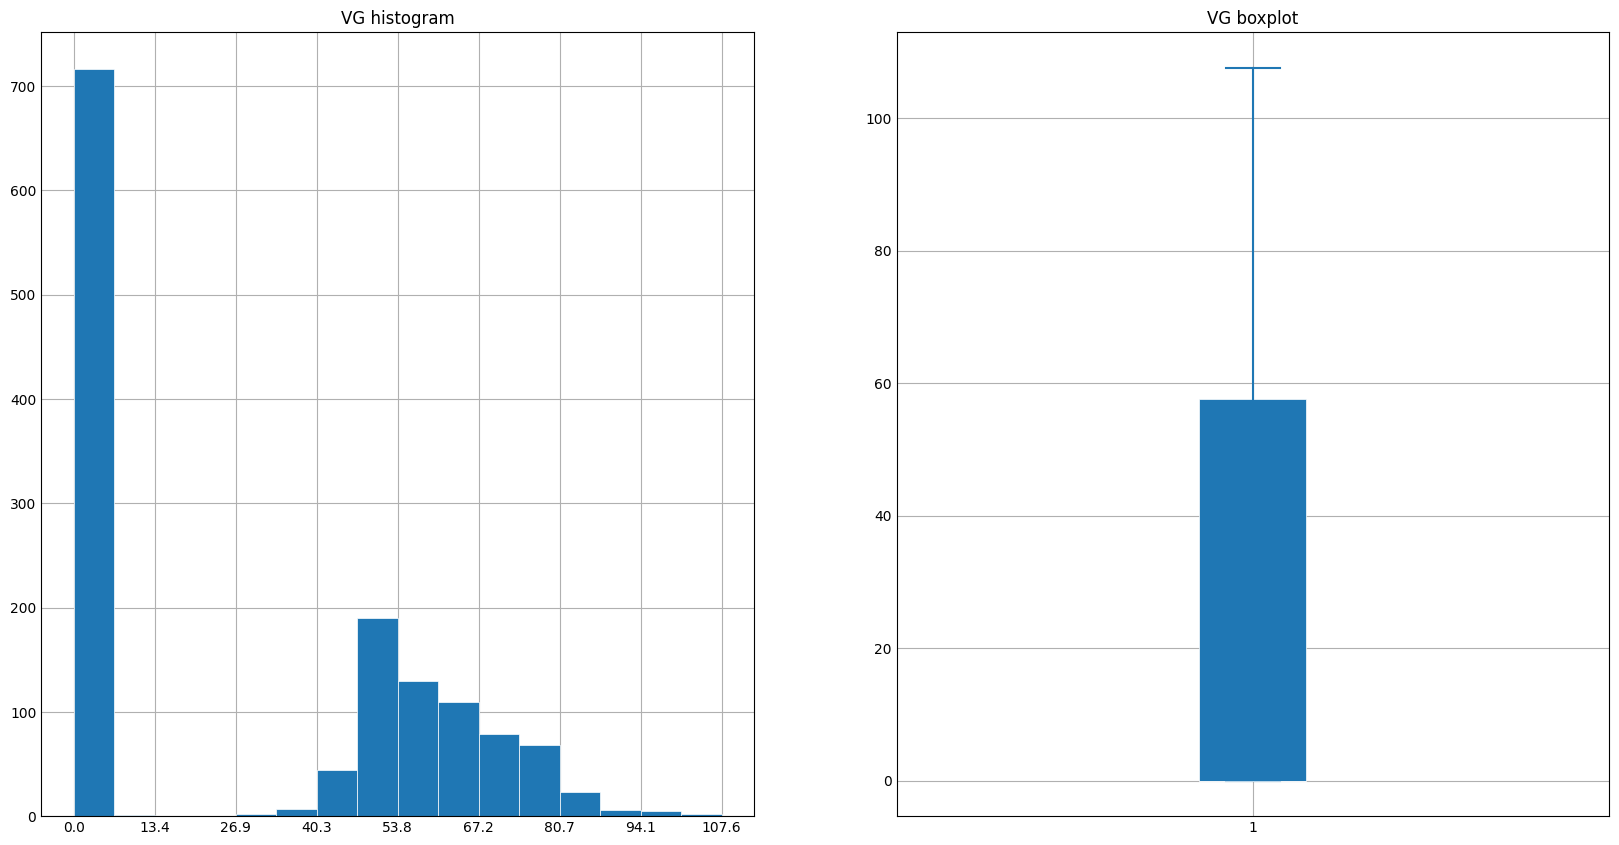

In [75]:
uncond_analysis = pd.DataFrame(columns=['name', 'mean', 'standard_deviation', 'skewness'])

for i, predictor in enumerate(df.columns):
    uncond_analysis.loc[i] = [predictor, df[predictor].mean(), df[predictor].std(), df[predictor].skew()]
    
    fig, axs = plt.subplots(1, 2, figsize=(16,8))
    
    _, bins, _ = axs[0].hist(df[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::2], title=f'{predictor} histogram')
    axs[1].boxplot(df[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

# For index starting at 1
uncond_analysis.index = uncond_analysis.index + 1
uncond_analysis